# EfficientNetB0 Baseline Training
**CSCI323 Facial Expression Recognition Project**

This notebook trains the EfficientNetB0 baseline model:
- Load pre-trained EfficientNetB0 (ImageNet weights)
- Add custom classification head
- Fine-tune all layers in a single phase
- Evaluate and collect metrics
- Generate visualizations

**Model:** EfficientNetB0
- Compound scaled architecture
- ~4.4M trainable parameters in this configuration
- Key innovation: Compound scaling (depth × width × resolution)

---

## 1. Setup and Imports

In [1]:
# Import required libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support
import pandas as pd
import os
import time
from datetime import datetime

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("\n✓ Libraries imported successfully!")

TensorFlow version: 2.16.2
Keras version: 3.12.0

✓ Libraries imported successfully!


In [ ]:
# Verify TensorFlow Metal GPU acceleration
import tensorflow as tf

print("="*60)
print("SYSTEM INFORMATION")
print("="*60)
print(f"TensorFlow version: {tf.__version__}")
print(f"\nAvailable devices:")
for device in tf.config.list_physical_devices():
    print(f"  {device}")

# Check for Metal GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"\n✓ Metal GPU acceleration available!")
    print(f"  Found {len(gpus)} GPU(s)")
    # Set memory growth
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("\n⚠️  No GPU found")

print("="*60)

SYSTEM INFORMATION
TensorFlow version: 2.16.2

Available devices:
  PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

✓ Metal GPU acceleration available!
  Found 1 GPU(s)


## 2. Setup Paths and Verify Metal Acceleration

In [ ]:
# Set up paths
import os

# Project root
PROJECT_ROOT = os.path.dirname(os.path.abspath('__file__'))
if PROJECT_ROOT == '':
    PROJECT_ROOT = os.getcwd()

# Dataset path - using local fer2013_data
DATASET_PATH = os.path.join(PROJECT_ROOT, 'fer2013_data')

RESULTS_PATH = os.path.join(PROJECT_ROOT, '04-Results')
MODELS_PATH = os.path.join(RESULTS_PATH, 'Models')
FIGURES_PATH = os.path.join(RESULTS_PATH, 'Figures')
METRICS_PATH = os.path.join(RESULTS_PATH, 'Metrics')

# Create directories if they don't exist
os.makedirs(MODELS_PATH, exist_ok=True)
os.makedirs(FIGURES_PATH, exist_ok=True)
os.makedirs(METRICS_PATH, exist_ok=True)

# Data paths
TRAIN_DIR = os.path.join(DATASET_PATH, 'train')
TEST_DIR = os.path.join(DATASET_PATH, 'test')

print(f"Project root: {PROJECT_ROOT}")
print(f"Dataset path: {DATASET_PATH}")
print(f"Models will be saved to: {MODELS_PATH}")
print(f"Figures will be saved to: {FIGURES_PATH}")
print(f"Metrics will be saved to: {METRICS_PATH}")
print(f"\nVerifying dataset...")
print(f"Training data exists: {os.path.exists(TRAIN_DIR)}")
print(f"Test data exists: {os.path.exists(TEST_DIR)}")

if not os.path.exists(TRAIN_DIR):
    print("\n⚠️  WARNING: Training directory not found!")
    print(f"   Expected: {TRAIN_DIR}")
    print("   Please check your dataset location.")

Project root: /Users/muhammadsalmaanahmednusrath/Library/CloudStorage/OneDrive-UniversityofWollongong/Uni/CSCI323/Project
Dataset path: /Users/muhammadsalmaanahmednusrath/Library/CloudStorage/OneDrive-UniversityofWollongong/Uni/CSCI323/Project/fer2013_data
Models will be saved to: /Users/muhammadsalmaanahmednusrath/Library/CloudStorage/OneDrive-UniversityofWollongong/Uni/CSCI323/Project/04-Results/Models
Figures will be saved to: /Users/muhammadsalmaanahmednusrath/Library/CloudStorage/OneDrive-UniversityofWollongong/Uni/CSCI323/Project/04-Results/Figures
Metrics will be saved to: /Users/muhammadsalmaanahmednusrath/Library/CloudStorage/OneDrive-UniversityofWollongong/Uni/CSCI323/Project/04-Results/Metrics

Verifying dataset...
Training data exists: True
Test data exists: True


In [ ]:


TRAIN_DIR = os.path.join(DATASET_PATH, 'train')
TEST_DIR = os.path.join(DATASET_PATH, 'test')

print("="*60)
print("DATASET VERIFICATION")
print("="*60)
print(f"Training data: {TRAIN_DIR}")
print(f"Test data: {TEST_DIR}")
print(f"Training data exists: {os.path.exists(TRAIN_DIR)}")
print(f"Test data exists: {os.path.exists(TEST_DIR)}")

if os.path.exists(TRAIN_DIR):
    classes = sorted([d for d in os.listdir(TRAIN_DIR) if os.path.isdir(os.path.join(TRAIN_DIR, d))])
    print(f"\nClasses found ({len(classes)}): {classes}")
print("="*60)

DATASET VERIFICATION
Training data: /Users/muhammadsalmaanahmednusrath/Library/CloudStorage/OneDrive-UniversityofWollongong/Uni/CSCI323/Project/fer2013_data/train
Test data: /Users/muhammadsalmaanahmednusrath/Library/CloudStorage/OneDrive-UniversityofWollongong/Uni/CSCI323/Project/fer2013_data/test
Training data exists: True
Test data exists: True

Classes found (7): ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


## 3. Configuration Parameters

In [6]:
# Image parameters
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3

# Training parameters
BATCH_SIZE = 64  # Increased from 32 for faster training (2x speedup)
VALIDATION_SPLIT = 0.2
EPOCHS = 35  # Reduced from 50 (early stopping will likely trigger before this)
INITIAL_LR = 1e-5  # 0.00001 for EfficientNet (more sensitive, needs gentler fine-tuning than VGG/ResNet)

# Model name
MODEL_NAME = 'EfficientNetB0'
TIMESTAMP = datetime.now().strftime('%Y%m%d_%H%M%S')

# Class labels
CLASS_NAMES = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
NUM_CLASSES = len(CLASS_NAMES)

print("="*60)
print("TRAINING CONFIGURATION")
print("="*60)
print(f"Model: {MODEL_NAME}")
print(f"Image size: {IMG_HEIGHT}×{IMG_WIDTH}×{IMG_CHANNELS}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Initial learning rate: {INITIAL_LR}")
print(f"Max epochs: {EPOCHS}")
print(f"Classes: {NUM_CLASSES}")
print("="*60)

TRAINING CONFIGURATION
Model: EfficientNetB0
Image size: 224×224×3
Batch size: 64
Initial learning rate: 1e-05
Max epochs: 35
Classes: 7


## 4. Create Data Generators

Reusing the preprocessing pipeline from notebook 03.

In [7]:
# Training data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest',
    validation_split=VALIDATION_SPLIT
)

# Test data - only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    subset='training',
    seed=42
)

validation_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,  # Don't shuffle validation
    subset='validation',
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    seed=42
)

print("\nData generators created:")
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")
print(f"\nClass indices: {train_generator.class_indices}")

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.

Data generators created:
Training samples: 22968
Validation samples: 5741
Test samples: 7178

Class indices: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


## 5. Load Class Weights

In [ ]:
# Load class weights 
class_weights_path = os.path.join(RESULTS_PATH, 'class_weights.npy')

if os.path.exists(class_weights_path):
    class_weights = np.load(class_weights_path, allow_pickle=True).item()
    print("Class weights loaded:")
    for idx, weight in class_weights.items():
        print(f"  {CLASS_NAMES[idx]:<12}: {weight:.4f}")
else:
    print("⚠️ Class weights not found. Training without class weights.")
    class_weights = None

Class weights loaded:
  angry       : 1.0266
  disgust     : 9.4066
  fear        : 1.0010
  happy       : 0.5684
  neutral     : 0.8260
  sad         : 0.8491
  surprise    : 1.2934


## 6. Build EfficientNetB0 Model

**Architecture:**
- Base: EfficientNetB0 pre-trained on ImageNet (all layers trainable)
- Head: GlobalAveragePooling2D → Dense(256) → Dropout(0.5) → Dense(7)

**Why full fine-tuning?**
- EfficientNet’s lightweight base benefits from adapting all layers to FER
- Keeps configuration consistent with the VGG16/ResNet50 Mac notebooks
- Eliminates phase switching so the notebook is reproducible end-to-end

In [9]:
def build_efficientnetb0_model(input_shape=(224, 224, 3), num_classes=7, freeze_base=False):  # Full fine-tuning
    """
    Build EfficientNetB0 model with custom classification head.
    
    Args:
        input_shape: Input image shape
        num_classes: Number of output classes
        freeze_base: Whether to freeze base EfficientNetB0 layers
    
    Returns:
        Compiled Keras model
    """
    # Load pre-trained EfficientNetB0 (without top classification layer)
    base_model = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    # Freeze base layers
    base_model.trainable = not freeze_base  # With freeze_base=False, this sets trainable=True
    
    # Build custom head
    x = base_model.output
    x = layers.GlobalAveragePooling2D(name='global_avg_pool')(x)
    x = layers.Dense(256, activation='relu', name='fc1')(x)
    x = layers.Dropout(0.5, name='dropout')(x)
    outputs = layers.Dense(num_classes, activation='softmax', name='predictions')(x)
    
    # Create model
    model = models.Model(inputs=base_model.input, outputs=outputs, name='EfficientNetB0_FER')
    
    return model, base_model

# Build model
model, base_model = build_efficientnetb0_model(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
    num_classes=NUM_CLASSES,
    freeze_base=False  # Full fine-tuning
)

print("\n" + "="*60)
print("MODEL ARCHITECTURE")
print("="*60)
model.summary()
print("="*60)

2025-11-09 10:36:36.768482: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2025-11-09 10:36:36.768512: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-11-09 10:36:36.768524: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2025-11-09 10:36:36.768560: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-09 10:36:36.768576: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)



MODEL ARCHITECTURE


Model: "EfficientNetB0_FER"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,379,306 (16.71 MB)

 Trainable params: 4,337,283 (16.55 MB)

 Non-trainable params: 42,023 (164.16 KB)

## 7. Model Statistics

In [ ]:
# Count parameters
total_params = model.count_params()
trainable_params = sum([tf.size(w).numpy() for w in model.trainable_weights])
non_trainable_params = total_params - trainable_params

print("\nModel Parameters:")
print(f"  Total: {total_params:,}")
print(f"  Trainable: {trainable_params:,}")
print(f"  Non-trainable (frozen): {non_trainable_params:,}")

# Layer breakdown
print(f"\nBase model (EfficientNetB0): {len(base_model.layers)} layers")
print(f"Total model layers: {len(model.layers)}")
print(f"\nBase model trainable: {base_model.trainable}")


Model Parameters:
  Total: 4,379,306
  Trainable: 4,337,283
  Non-trainable (frozen): 42,023

Base model (VGG16): 238 layers
Total model layers: 242

Base model trainable: True


## 8. Compile Model

In [11]:
# Compile model
model.compile(
    optimizer=optimizers.Adam(learning_rate=INITIAL_LR),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\n✓ Model compiled successfully!")
print(f"  Optimizer: Adam (lr={INITIAL_LR})")
print(f"  Loss: Categorical Cross-Entropy")
print(f"  Metrics: Accuracy")


✓ Model compiled successfully!
  Optimizer: Adam (lr=1e-05)
  Loss: Categorical Cross-Entropy
  Metrics: Accuracy


## 9. Setup Training Callbacks

**Callbacks:**
1. **ModelCheckpoint**: Save best model based on validation accuracy
2. **EarlyStopping**: Stop if no improvement for 7 epochs
3. **ReduceLROnPlateau**: Reduce learning rate if plateau detected
4. **CSVLogger**: Log training metrics to CSV

In [12]:
# Define callbacks
model_checkpoint = callbacks.ModelCheckpoint(
    filepath=os.path.join(MODELS_PATH, f'{MODEL_NAME}_best.keras'),
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,  # Reduced from 7 for faster training
    restore_best_weights=True,
    mode='max',
    verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    mode='min',
    verbose=1
)

csv_logger = callbacks.CSVLogger(
    filename=os.path.join(METRICS_PATH, f'{MODEL_NAME}_training_log.csv'),
    append=False
)

callback_list = [model_checkpoint, early_stopping, reduce_lr, csv_logger]

print("\n✓ Callbacks configured:")
print("  - ModelCheckpoint (save best model)")
print("  - EarlyStopping (patience=5)")
print("  - ReduceLROnPlateau (factor=0.5, patience=3)")
print("  - CSVLogger (save training history)")


✓ Callbacks configured:
  - ModelCheckpoint (save best model)
  - EarlyStopping (patience=5)
  - ReduceLROnPlateau (factor=0.5, patience=3)
  - CSVLogger (save training history)


## 10. Train Model

**Full Fine-Tuning (Single Phase)**

We fine-tune the entire EfficientNetB0 backbone plus the custom head with a gentle learning rate and early stopping—no freeze/unfreeze cycling needed.

In [13]:
print("\n" + "="*60)
print("STARTING TRAINING")
print("="*60)
print(f"Model: {MODEL_NAME}")
print(f"Timestamp: {TIMESTAMP}")
print(f"Max epochs: {EPOCHS}")
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print("="*60)

# Record start time
start_time = time.time()

# Train model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks=callback_list,
    class_weight=class_weights,
    verbose=1
)

# Record end time
end_time = time.time()
training_time = end_time - start_time

print("\n" + "="*60)
print("TRAINING COMPLETE!")
print("="*60)
print(f"Total training time: {training_time/60:.2f} minutes")
print(f"Average time per epoch: {training_time/len(history.history['loss']):.2f} seconds")
print("="*60)


STARTING TRAINING
Model: EfficientNetB0
Timestamp: 20251109_103636
Max epochs: 35
Training samples: 22968
Validation samples: 5741
Epoch 1/35


2025-11-09 10:36:44.292667: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1368 - loss: 2.1130
Epoch 1: val_accuracy improved from None to 0.09841, saving model to /Users/muhammadsalmaanahmednusrath/Library/CloudStorage/OneDrive-UniversityofWollongong/Uni/CSCI323/Project/04-Results/Models/EfficientNetB0_best.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 590s 2s/step - accuracy: 0.1501 - loss: 2.0853 - val_accuracy: 0.0984 - val_loss: 1.9894 - learning_rate: 1.0000e-05
Epoch 2/35
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1803 - loss: 2.0372
Epoch 2: val_accuracy improved from 0.09841 to 0.15311, saving model to /Users/muhammadsalmaanahmednusrath/Library/CloudStorage/OneDrive-UniversityofWollongong/Uni/CSCI323/Project/04-Results/Models/EfficientNetB0_best.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 555s 2s/step - accuracy: 0.1839 - loss: 2.0139 - val_accuracy: 0.1531 - val_loss: 1.9386 - learning_rate: 1.0000e-05
Epoch 3/35
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1965 - loss: 1.9771
Epoch 3: val_accura

## 11. Save Training History

In [14]:
# Save history to numpy file
history_path = os.path.join(METRICS_PATH, f'{MODEL_NAME}_history.npy')
np.save(history_path, history.history)
print(f"\n✓ Training history saved to: {history_path}")

# Save training summary
summary = {
    'model': MODEL_NAME,
    'timestamp': TIMESTAMP,
    'total_epochs': len(history.history['loss']),
    'training_time_minutes': training_time/60,
    'final_train_accuracy': float(history.history['accuracy'][-1]),
    'final_val_accuracy': float(history.history['val_accuracy'][-1]),
    'best_val_accuracy': float(max(history.history['val_accuracy'])),
    'final_train_loss': float(history.history['loss'][-1]),
    'final_val_loss': float(history.history['val_loss'][-1]),
    'trainable_params': int(trainable_params),
    'total_params': int(total_params)
}

import json
summary_path = os.path.join(METRICS_PATH, f'{MODEL_NAME}_training_summary.json')
with open(summary_path, 'w') as f:
    json.dump(summary, f, indent=2)

print(f"✓ Training summary saved to: {summary_path}")
print("\nTraining Summary:")
for key, value in summary.items():
    print(f"  {key}: {value}")


✓ Training history saved to: /Users/muhammadsalmaanahmednusrath/Library/CloudStorage/OneDrive-UniversityofWollongong/Uni/CSCI323/Project/04-Results/Metrics/EfficientNetB0_history.npy
✓ Training summary saved to: /Users/muhammadsalmaanahmednusrath/Library/CloudStorage/OneDrive-UniversityofWollongong/Uni/CSCI323/Project/04-Results/Metrics/EfficientNetB0_training_summary.json

Training Summary:
  model: EfficientNetB0
  timestamp: 20251109_103636
  total_epochs: 30
  training_time_minutes: 282.5121022502581
  final_train_accuracy: 0.3587164878845215
  final_val_accuracy: 0.390524297952652
  best_val_accuracy: 0.39975613355636597
  final_train_loss: 1.642491102218628
  final_val_loss: 1.570363163948059
  trainable_params: 4337283
  total_params: 4379306


## 12. Visualize Training History


✓ Training curves saved to: /Users/muhammadsalmaanahmednusrath/Library/CloudStorage/OneDrive-UniversityofWollongong/Uni/CSCI323/Project/04-Results/Figures/EfficientNetB0_training_curves.png


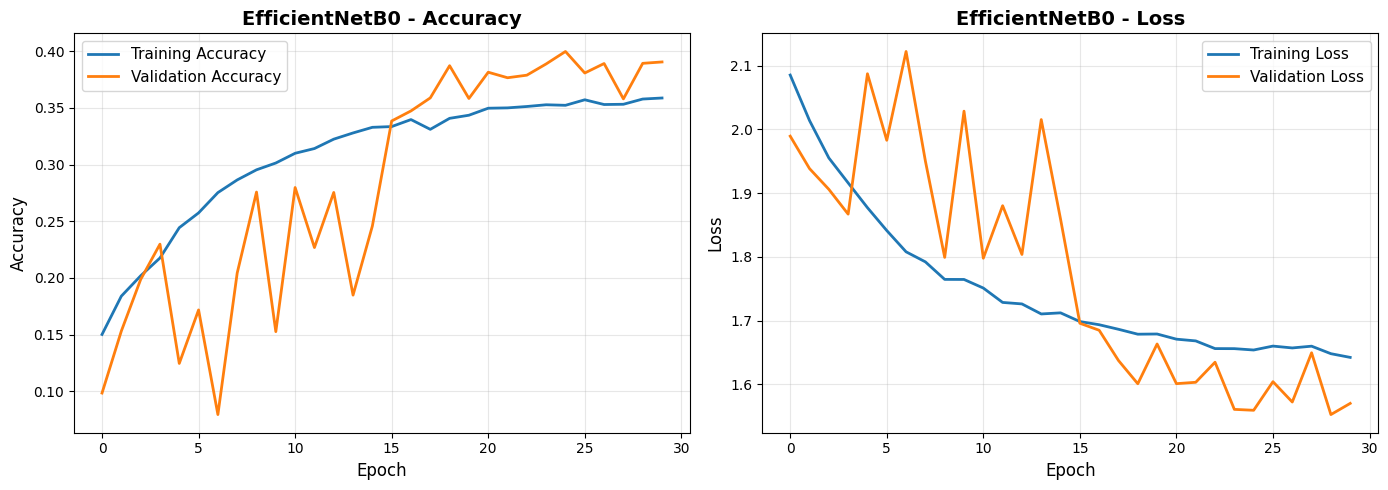

In [15]:
def plot_training_history(history, model_name, save_path):
    """
    Plot training and validation accuracy/loss curves.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Accuracy plot
    axes[0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    axes[0].set_title(f'{model_name} - Accuracy', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Accuracy', fontsize=12)
    axes[0].legend(fontsize=11)
    axes[0].grid(True, alpha=0.3)
    
    # Loss plot
    axes[1].plot(history.history['loss'], label='Training Loss', linewidth=2)
    axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    axes[1].set_title(f'{model_name} - Loss', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Loss', fontsize=12)
    axes[1].legend(fontsize=11)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"\n✓ Training curves saved to: {save_path}")
    plt.show()

# Plot training curves
curves_path = os.path.join(FIGURES_PATH, f'{MODEL_NAME}_training_curves.png')
plot_training_history(history, MODEL_NAME, curves_path)

## 13. Load Best Model for Evaluation

In [16]:
# Load the best model (saved by ModelCheckpoint)
best_model_path = os.path.join(MODELS_PATH, f'{MODEL_NAME}_best.keras')
model = keras.models.load_model(best_model_path)
print(f"\n✓ Best model loaded from: {best_model_path}")


✓ Best model loaded from: /Users/muhammadsalmaanahmednusrath/Library/CloudStorage/OneDrive-UniversityofWollongong/Uni/CSCI323/Project/04-Results/Models/EfficientNetB0_best.keras


## 14. Evaluate on Test Set

In [17]:
print("\n" + "="*60)
print("EVALUATING ON TEST SET")
print("="*60)

# Evaluate
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)

print("\nTest Results:")
print(f"  Test Loss: {test_loss:.4f}")
print(f"  Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print("="*60)


EVALUATING ON TEST SET
113/113 ━━━━━━━━━━━━━━━━━━━━ 24s 165ms/step - accuracy: 0.3781 - loss: 1.6246

Test Results:
  Test Loss: 1.6246
  Test Accuracy: 0.3781 (37.81%)


## 15. Generate Predictions for Detailed Metrics

In [18]:
# Reset generator
test_generator.reset()

# Get predictions
print("\nGenerating predictions on test set...")
y_pred_probs = model.predict(test_generator, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

# Get true labels
y_true = test_generator.classes

print(f"\nPredictions shape: {y_pred_probs.shape}")
print(f"True labels shape: {y_true.shape}")
print(f"Number of test samples: {len(y_true)}")


Generating predictions on test set...
113/113 ━━━━━━━━━━━━━━━━━━━━ 21s 169ms/step

Predictions shape: (7178, 7)
True labels shape: (7178,)
Number of test samples: 7178


## 16. Classification Report

In [19]:
# Generate classification report
print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)

report = classification_report(
    y_true, 
    y_pred, 
    target_names=CLASS_NAMES,
    digits=4
)
print(report)

# Save report
report_path = os.path.join(METRICS_PATH, f'{MODEL_NAME}_classification_report.txt')
with open(report_path, 'w') as f:
    f.write(report)
print(f"\n✓ Classification report saved to: {report_path}")


CLASSIFICATION REPORT
              precision    recall  f1-score   support

       angry     0.2766    0.2881    0.2822       958
     disgust     0.0907    0.2973    0.1389       111
        fear     0.2396    0.0898    0.1307      1024
       happy     0.7200    0.4059    0.5191      1774
     neutral     0.3214    0.5101    0.3944      1233
         sad     0.3184    0.3424    0.3300      1247
    surprise     0.4735    0.6462    0.5466       831

    accuracy                         0.3781      7178
   macro avg     0.3486    0.3686    0.3346      7178
weighted avg     0.4158    0.3781    0.3751      7178


✓ Classification report saved to: /Users/muhammadsalmaanahmednusrath/Library/CloudStorage/OneDrive-UniversityofWollongong/Uni/CSCI323/Project/04-Results/Metrics/EfficientNetB0_classification_report.txt


## 17. Per-Class Metrics Table

In [20]:
# Calculate per-class metrics
precision, recall, f1, support = precision_recall_fscore_support(
    y_true, y_pred, average=None, labels=range(NUM_CLASSES)
)

# Create DataFrame
metrics_df = pd.DataFrame({
    'Class': CLASS_NAMES,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

# Add macro averages
macro_precision, macro_recall, macro_f1, _ = precision_recall_fscore_support(
    y_true, y_pred, average='macro'
)

metrics_df.loc[len(metrics_df)] = ['Macro Avg', macro_precision, macro_recall, macro_f1, sum(support)]

print("\n" + "="*60)
print("PER-CLASS METRICS")
print("="*60)
print(metrics_df.to_string(index=False))
print("="*60)

# Save to CSV
metrics_csv_path = os.path.join(METRICS_PATH, f'{MODEL_NAME}_per_class_metrics.csv')
metrics_df.to_csv(metrics_csv_path, index=False)
print(f"\n✓ Per-class metrics saved to: {metrics_csv_path}")


PER-CLASS METRICS
    Class  Precision   Recall  F1-Score  Support
    angry   0.276553 0.288100  0.282209      958
  disgust   0.090659 0.297297  0.138947      111
     fear   0.239583 0.089844  0.130682     1024
    happy   0.720000 0.405862  0.519106     1774
  neutral   0.321410 0.510138  0.394357     1233
      sad   0.318419 0.342422  0.329985     1247
 surprise   0.473545 0.646209  0.546565      831
Macro Avg   0.348596 0.368553  0.334550     7178

✓ Per-class metrics saved to: /Users/muhammadsalmaanahmednusrath/Library/CloudStorage/OneDrive-UniversityofWollongong/Uni/CSCI323/Project/04-Results/Metrics/EfficientNetB0_per_class_metrics.csv


## 18. Confusion Matrix


✓ Confusion matrix saved to: /Users/muhammadsalmaanahmednusrath/Library/CloudStorage/OneDrive-UniversityofWollongong/Uni/CSCI323/Project/04-Results/Figures/EfficientNetB0_confusion_matrix.png


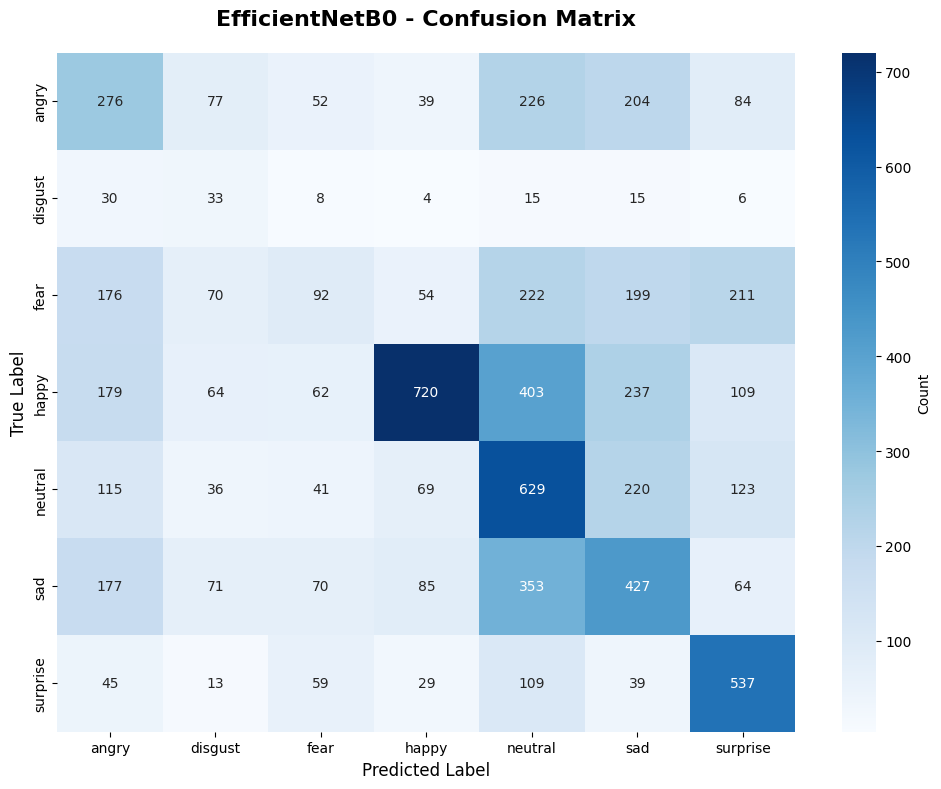

✓ Confusion matrix CSV saved to: /Users/muhammadsalmaanahmednusrath/Library/CloudStorage/OneDrive-UniversityofWollongong/Uni/CSCI323/Project/04-Results/Metrics/EfficientNetB0_confusion_matrix.csv


In [21]:
# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=CLASS_NAMES,
    yticklabels=CLASS_NAMES,
    cbar_kws={'label': 'Count'}
)
plt.title(f'{MODEL_NAME} - Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()

# Save figure
cm_path = os.path.join(FIGURES_PATH, f'{MODEL_NAME}_confusion_matrix.png')
plt.savefig(cm_path, dpi=300, bbox_inches='tight')
print(f"\n✓ Confusion matrix saved to: {cm_path}")
plt.show()

# Save confusion matrix as CSV
cm_df = pd.DataFrame(cm, index=CLASS_NAMES, columns=CLASS_NAMES)
cm_csv_path = os.path.join(METRICS_PATH, f'{MODEL_NAME}_confusion_matrix.csv')
cm_df.to_csv(cm_csv_path)
print(f"✓ Confusion matrix CSV saved to: {cm_csv_path}")

## 19. Normalized Confusion Matrix (Percentages)


✓ Normalized confusion matrix saved to: /Users/muhammadsalmaanahmednusrath/Library/CloudStorage/OneDrive-UniversityofWollongong/Uni/CSCI323/Project/04-Results/Figures/EfficientNetB0_confusion_matrix_normalized.png


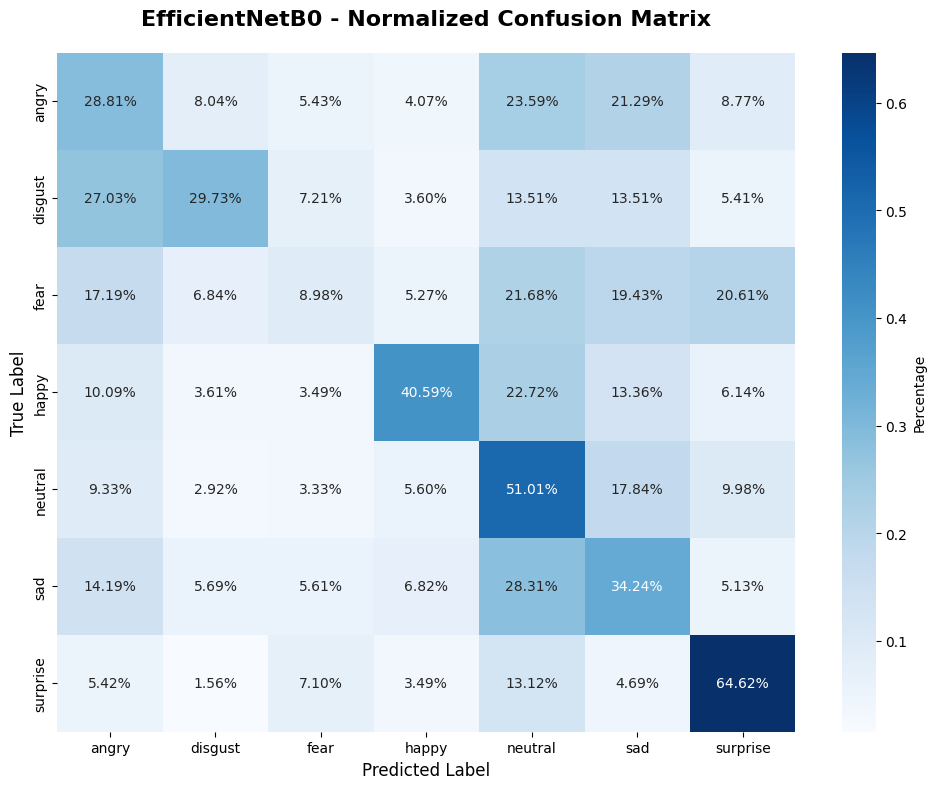

In [22]:
# Normalize confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_normalized, 
    annot=True, 
    fmt='.2%', 
    cmap='Blues',
    xticklabels=CLASS_NAMES,
    yticklabels=CLASS_NAMES,
    cbar_kws={'label': 'Percentage'}
)
plt.title(f'{MODEL_NAME} - Normalized Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()

# Save figure
cm_norm_path = os.path.join(FIGURES_PATH, f'{MODEL_NAME}_confusion_matrix_normalized.png')
plt.savefig(cm_norm_path, dpi=300, bbox_inches='tight')
print(f"\n✓ Normalized confusion matrix saved to: {cm_norm_path}")
plt.show()

## 20. Measure Inference Time

In [23]:
# Measure inference time on a batch
test_generator.reset()
test_batch = next(test_generator)
test_images, _ = test_batch

# Warm-up
_ = model.predict(test_images[:1], verbose=0)

# Measure time for single image
num_runs = 100
times = []

for _ in range(num_runs):
    start = time.time()
    _ = model.predict(test_images[:1], verbose=0)
    end = time.time()
    times.append(end - start)

avg_inference_time = np.mean(times) * 1000  # Convert to milliseconds
std_inference_time = np.std(times) * 1000

print("\n" + "="*60)
print("INFERENCE TIME")
print("="*60)
print(f"Average time per image: {avg_inference_time:.2f} ms")
print(f"Standard deviation: {std_inference_time:.2f} ms")
print(f"Throughput: {1000/avg_inference_time:.2f} images/second")
print("="*60)


INFERENCE TIME
Average time per image: 58.64 ms
Standard deviation: 132.55 ms
Throughput: 17.05 images/second


## 21. Final Summary and Results

In [ ]:
print("\n" + "="*70)
print(f"{MODEL_NAME} - FINAL RESULTS SUMMARY")
print("="*70)

print("\n📊 MODEL CHARACTERISTICS:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Model size: ~{total_params * 4 / (1024**2):.1f} MB (float32)")

print("\n⏱️  TRAINING:")
print(f"  Total epochs: {len(history.history['loss'])}")
print(f"  Training time: {training_time/60:.2f} minutes")
print(f"  Time per epoch: {training_time/len(history.history['loss']):.2f} seconds")

print("\n📈 PERFORMANCE:")
print(f"  Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"  Test Loss: {test_loss:.4f}")
print(f"  Macro Precision: {macro_precision:.4f}")
print(f"  Macro Recall: {macro_recall:.4f}")
print(f"  Macro F1-Score: {macro_f1:.4f}")

print("\n⚡ EFFICIENCY:")
print(f"  Inference time: {avg_inference_time:.2f} ms/image")
print(f"  Throughput: {1000/avg_inference_time:.2f} images/second")

print("\n📁 SAVED FILES:")
print(f"  Model: {MODELS_PATH}/{MODEL_NAME}_best.keras")
print(f"  Training curves: {FIGURES_PATH}/{MODEL_NAME}_training_curves.png")
print(f"  Confusion matrix: {FIGURES_PATH}/{MODEL_NAME}_confusion_matrix.png")
print(f"  Metrics CSV: {METRICS_PATH}/{MODEL_NAME}_per_class_metrics.csv")
print(f"  Training log: {METRICS_PATH}/{MODEL_NAME}_training_log.csv")

print("\n" + "="*70)
print("✓ EFFICIENTNETB0 BASELINE TRAINING COMPLETE!")
print("="*70)


EfficientNetB0 - FINAL RESULTS SUMMARY

📊 MODEL CHARACTERISTICS:
  Total parameters: 4,379,306
  Trainable parameters: 4,337,283
  Model size: ~16.7 MB (float32)

⏱️  TRAINING:
  Total epochs: 30
  Training time: 282.51 minutes
  Time per epoch: 565.02 seconds

📈 PERFORMANCE:
  Test Accuracy: 0.3781 (37.81%)
  Test Loss: 1.6246
  Macro Precision: 0.3486
  Macro Recall: 0.3686
  Macro F1-Score: 0.3346

⚡ EFFICIENCY:
  Inference time: 58.64 ms/image
  Throughput: 17.05 images/second

📁 SAVED FILES:
  Model: /Users/muhammadsalmaanahmednusrath/Library/CloudStorage/OneDrive-UniversityofWollongong/Uni/CSCI323/Project/04-Results/Models/EfficientNetB0_best.keras
  Training curves: /Users/muhammadsalmaanahmednusrath/Library/CloudStorage/OneDrive-UniversityofWollongong/Uni/CSCI323/Project/04-Results/Figures/EfficientNetB0_training_curves.png
  Confusion matrix: /Users/muhammadsalmaanahmednusrath/Library/CloudStorage/OneDrive-UniversityofWollongong/Uni/CSCI323/Project/04-Results/Figures/Efficien